# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

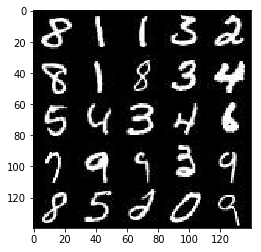

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

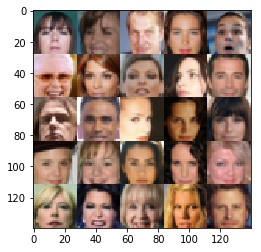

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/osboxes/Development/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [49]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [50]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        layer3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4 * 4 *256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [51]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = is_train != True
    with tf.variable_scope('generator', reuse=reuse):
        
        layer1 = tf.layers.dense(z, 7 * 7 * 512)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        layer1 = tf.nn.dropout(layer1, 0.5)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, 0.5)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, 0.5)
        
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 3, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [52]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [53]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [57]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
    print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0023... Generator Loss: 21.0222
Epoch 1/2... Discriminator Loss: 1.5465... Generator Loss: 1.1717
Epoch 1/2... Discriminator Loss: 0.8710... Generator Loss: 2.5255
Epoch 1/2... Discriminator Loss: 0.5381... Generator Loss: 3.1324
Epoch 1/2... Discriminator Loss: 0.3061... Generator Loss: 2.4627
Epoch 1/2... Discriminator Loss: 1.1701... Generator Loss: 1.3043
Epoch 1/2... Discriminator Loss: 1.6255... Generator Loss: 2.5425
Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 3.2184
Epoch 1/2... Discriminator Loss: 0.8038... Generator Loss: 1.6909
Epoch 1/2... Discriminator Loss: 0.6507... Generator Loss: 2.1231


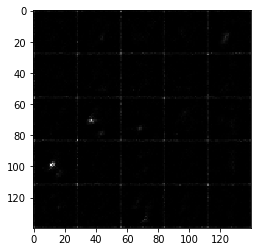

Epoch 1/2... Discriminator Loss: 0.8877... Generator Loss: 0.9953
Epoch 1/2... Discriminator Loss: 1.5497... Generator Loss: 0.4061
Epoch 1/2... Discriminator Loss: 0.6619... Generator Loss: 1.3986
Epoch 1/2... Discriminator Loss: 0.8593... Generator Loss: 0.9531
Epoch 1/2... Discriminator Loss: 0.6721... Generator Loss: 1.1995
Epoch 1/2... Discriminator Loss: 0.5823... Generator Loss: 2.1516
Epoch 1/2... Discriminator Loss: 0.8841... Generator Loss: 2.6420
Epoch 1/2... Discriminator Loss: 0.7248... Generator Loss: 2.8569
Epoch 1/2... Discriminator Loss: 0.9348... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 1.1421


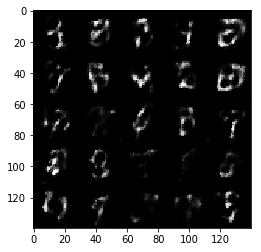

Epoch 1/2... Discriminator Loss: 0.7220... Generator Loss: 1.3619
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 0.8454
Epoch 1/2... Discriminator Loss: 0.7150... Generator Loss: 1.2791
Epoch 1/2... Discriminator Loss: 0.8087... Generator Loss: 1.1768
Epoch 1/2... Discriminator Loss: 1.0167... Generator Loss: 1.6946
Epoch 1/2... Discriminator Loss: 1.0097... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 0.9803... Generator Loss: 0.7263
Epoch 1/2... Discriminator Loss: 1.1058... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 0.7252... Generator Loss: 1.2543
Epoch 1/2... Discriminator Loss: 1.0151... Generator Loss: 1.6763


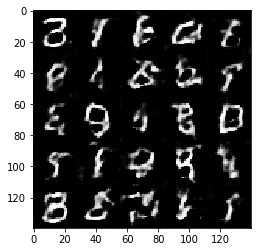

Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.4755
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 2.5381
Epoch 1/2... Discriminator Loss: 1.5215... Generator Loss: 0.4199
Epoch 1/2... Discriminator Loss: 0.8461... Generator Loss: 1.3283
Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 0.3741
Epoch 1/2... Discriminator Loss: 0.7753... Generator Loss: 0.9588
Epoch 1/2... Discriminator Loss: 0.7352... Generator Loss: 1.1018
Epoch 1/2... Discriminator Loss: 1.0438... Generator Loss: 0.6514
Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 2.0846
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 2.6545


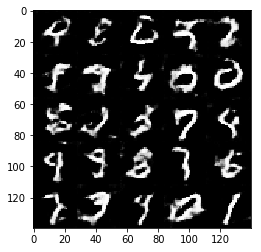

Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 0.7315
Epoch 1/2... Discriminator Loss: 0.7834... Generator Loss: 0.9365
Epoch 1/2... Discriminator Loss: 0.7476... Generator Loss: 1.2914
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.4341
Epoch 1/2... Discriminator Loss: 0.5622... Generator Loss: 1.3906
Epoch 1/2... Discriminator Loss: 0.9039... Generator Loss: 2.0735
Epoch 1/2... Discriminator Loss: 0.7334... Generator Loss: 1.0500
Epoch 1/2... Discriminator Loss: 0.6225... Generator Loss: 1.2870
Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 1.5674
Epoch 1/2... Discriminator Loss: 0.8237... Generator Loss: 0.9770


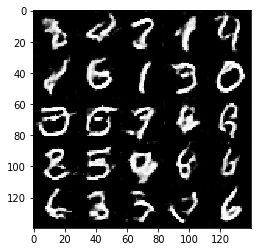

Epoch 1/2... Discriminator Loss: 0.7673... Generator Loss: 1.1192
Epoch 1/2... Discriminator Loss: 0.5504... Generator Loss: 2.1322
Epoch 1/2... Discriminator Loss: 0.8667... Generator Loss: 0.9566
Epoch 1/2... Discriminator Loss: 0.7109... Generator Loss: 1.0463
Epoch 1/2... Discriminator Loss: 0.7044... Generator Loss: 1.9837
Epoch 1/2... Discriminator Loss: 0.7051... Generator Loss: 1.1638
Epoch 1/2... Discriminator Loss: 0.5859... Generator Loss: 2.2316
Epoch 1/2... Discriminator Loss: 0.6553... Generator Loss: 1.3447
Epoch 1/2... Discriminator Loss: 2.1348... Generator Loss: 0.2955
Epoch 1/2... Discriminator Loss: 0.7746... Generator Loss: 1.0862


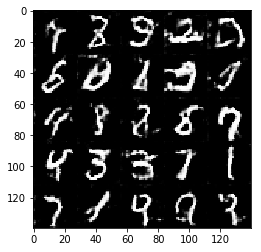

Epoch 1/2... Discriminator Loss: 0.6357... Generator Loss: 1.6386
Epoch 1/2... Discriminator Loss: 0.6473... Generator Loss: 1.6122
Epoch 1/2... Discriminator Loss: 0.8364... Generator Loss: 2.0307
Epoch 1/2... Discriminator Loss: 0.6142... Generator Loss: 1.8594
Epoch 1/2... Discriminator Loss: 0.5539... Generator Loss: 1.5141
Epoch 1/2... Discriminator Loss: 0.7016... Generator Loss: 1.4118
Epoch 1/2... Discriminator Loss: 0.5982... Generator Loss: 1.6638
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 2.3248
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 2.6414
Epoch 1/2... Discriminator Loss: 0.7324... Generator Loss: 0.9592


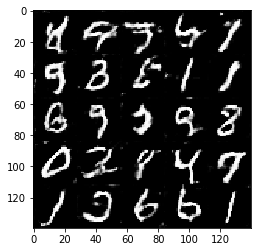

Epoch 1/2... Discriminator Loss: 0.6088... Generator Loss: 1.6682
Epoch 1/2... Discriminator Loss: 0.5790... Generator Loss: 2.4030
Epoch 1/2... Discriminator Loss: 0.6644... Generator Loss: 1.4932
Epoch 1/2... Discriminator Loss: 0.6687... Generator Loss: 0.9942
Epoch 1/2... Discriminator Loss: 0.4418... Generator Loss: 2.1051
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.4413
Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 0.7406... Generator Loss: 2.3893
Epoch 1/2... Discriminator Loss: 0.5837... Generator Loss: 1.8916
Epoch 1/2... Discriminator Loss: 0.6095... Generator Loss: 1.5216


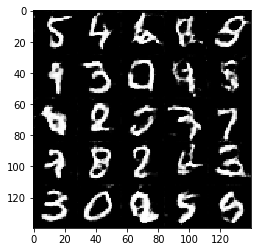

Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 0.5987
Epoch 1/2... Discriminator Loss: 0.4672... Generator Loss: 1.9426
Epoch 1/2... Discriminator Loss: 0.4649... Generator Loss: 1.4189
Epoch 1/2... Discriminator Loss: 0.5449... Generator Loss: 1.8611
Epoch 1/2... Discriminator Loss: 1.5700... Generator Loss: 0.3806
Epoch 1/2... Discriminator Loss: 0.5033... Generator Loss: 2.2672
Epoch 1/2... Discriminator Loss: 0.6259... Generator Loss: 1.6716
Epoch 1/2... Discriminator Loss: 0.6963... Generator Loss: 2.4728
Epoch 1/2... Discriminator Loss: 0.4934... Generator Loss: 1.7327
Epoch 1/2... Discriminator Loss: 0.4619... Generator Loss: 2.0996


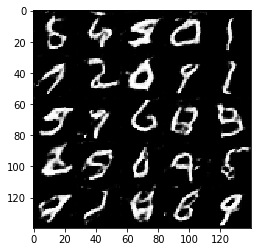

Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 1.2002
Epoch 1/2... Discriminator Loss: 0.5221... Generator Loss: 1.6734
Epoch 1/2... Discriminator Loss: 0.5294... Generator Loss: 1.5080
Epoch 2/2... Discriminator Loss: 0.4947... Generator Loss: 1.2529
Epoch 2/2... Discriminator Loss: 0.4836... Generator Loss: 1.6939
Epoch 2/2... Discriminator Loss: 0.4415... Generator Loss: 1.8071
Epoch 2/2... Discriminator Loss: 0.7118... Generator Loss: 1.0251
Epoch 2/2... Discriminator Loss: 0.5215... Generator Loss: 1.8321
Epoch 2/2... Discriminator Loss: 0.4230... Generator Loss: 3.0267
Epoch 2/2... Discriminator Loss: 0.2751... Generator Loss: 1.8512


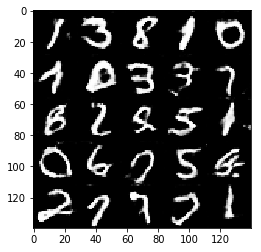

Epoch 2/2... Discriminator Loss: 0.3454... Generator Loss: 1.8320
Epoch 2/2... Discriminator Loss: 0.2810... Generator Loss: 2.6783
Epoch 2/2... Discriminator Loss: 0.3548... Generator Loss: 1.8695
Epoch 2/2... Discriminator Loss: 0.5765... Generator Loss: 1.6981
Epoch 2/2... Discriminator Loss: 0.4145... Generator Loss: 2.7483
Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 1.0761
Epoch 2/2... Discriminator Loss: 1.2222... Generator Loss: 0.5948
Epoch 2/2... Discriminator Loss: 0.5456... Generator Loss: 1.9978
Epoch 2/2... Discriminator Loss: 0.3187... Generator Loss: 2.9247
Epoch 2/2... Discriminator Loss: 0.3475... Generator Loss: 2.1805


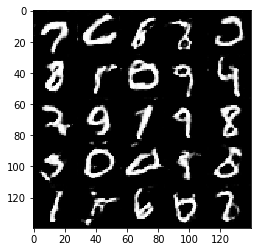

Epoch 2/2... Discriminator Loss: 0.7031... Generator Loss: 1.0293
Epoch 2/2... Discriminator Loss: 0.7586... Generator Loss: 3.7687
Epoch 2/2... Discriminator Loss: 0.6046... Generator Loss: 1.4720
Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 1.7228
Epoch 2/2... Discriminator Loss: 0.4358... Generator Loss: 2.3730
Epoch 2/2... Discriminator Loss: 0.4073... Generator Loss: 1.8375
Epoch 2/2... Discriminator Loss: 0.5246... Generator Loss: 1.5531
Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 0.6819
Epoch 2/2... Discriminator Loss: 0.3010... Generator Loss: 2.1218
Epoch 2/2... Discriminator Loss: 0.7649... Generator Loss: 1.2081


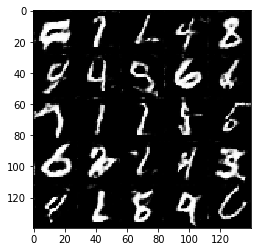

Epoch 2/2... Discriminator Loss: 0.5173... Generator Loss: 1.3801
Epoch 2/2... Discriminator Loss: 0.3291... Generator Loss: 2.6374
Epoch 2/2... Discriminator Loss: 0.6865... Generator Loss: 2.8794
Epoch 2/2... Discriminator Loss: 0.5068... Generator Loss: 1.9412
Epoch 2/2... Discriminator Loss: 0.2748... Generator Loss: 2.2615
Epoch 2/2... Discriminator Loss: 1.4984... Generator Loss: 0.5262
Epoch 2/2... Discriminator Loss: 0.3815... Generator Loss: 2.0115
Epoch 2/2... Discriminator Loss: 0.7263... Generator Loss: 1.0751
Epoch 2/2... Discriminator Loss: 0.5051... Generator Loss: 1.6054
Epoch 2/2... Discriminator Loss: 0.5965... Generator Loss: 3.8489


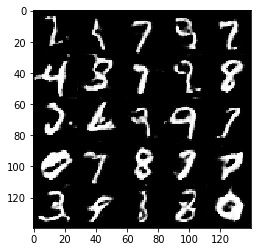

Epoch 2/2... Discriminator Loss: 0.4489... Generator Loss: 1.7520
Epoch 2/2... Discriminator Loss: 0.3622... Generator Loss: 1.6473
Epoch 2/2... Discriminator Loss: 0.2648... Generator Loss: 3.0215
Epoch 2/2... Discriminator Loss: 0.4477... Generator Loss: 3.2260
Epoch 2/2... Discriminator Loss: 1.1352... Generator Loss: 0.6980
Epoch 2/2... Discriminator Loss: 0.3943... Generator Loss: 2.0160
Epoch 2/2... Discriminator Loss: 0.3155... Generator Loss: 2.2361
Epoch 2/2... Discriminator Loss: 0.3154... Generator Loss: 2.6744
Epoch 2/2... Discriminator Loss: 1.0718... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 0.8322... Generator Loss: 1.3875


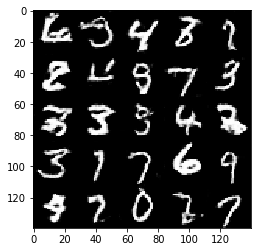

Epoch 2/2... Discriminator Loss: 1.5741... Generator Loss: 3.5962
Epoch 2/2... Discriminator Loss: 0.6369... Generator Loss: 1.5706
Epoch 2/2... Discriminator Loss: 0.4069... Generator Loss: 2.1166
Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 1.3443
Epoch 2/2... Discriminator Loss: 0.3537... Generator Loss: 2.7849
Epoch 2/2... Discriminator Loss: 0.5328... Generator Loss: 1.7038
Epoch 2/2... Discriminator Loss: 0.5480... Generator Loss: 1.5026
Epoch 2/2... Discriminator Loss: 0.3828... Generator Loss: 1.6788
Epoch 2/2... Discriminator Loss: 0.3927... Generator Loss: 1.6512
Epoch 2/2... Discriminator Loss: 0.3568... Generator Loss: 2.2178


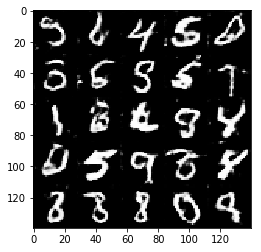

Epoch 2/2... Discriminator Loss: 0.3315... Generator Loss: 2.4393
Epoch 2/2... Discriminator Loss: 0.5459... Generator Loss: 1.3282
Epoch 2/2... Discriminator Loss: 0.2769... Generator Loss: 2.1799
Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 1.3109
Epoch 2/2... Discriminator Loss: 0.2214... Generator Loss: 3.5116
Epoch 2/2... Discriminator Loss: 0.4965... Generator Loss: 1.4585
Epoch 2/2... Discriminator Loss: 0.7112... Generator Loss: 1.3504
Epoch 2/2... Discriminator Loss: 0.9534... Generator Loss: 0.8083
Epoch 2/2... Discriminator Loss: 0.4722... Generator Loss: 1.2529
Epoch 2/2... Discriminator Loss: 0.4794... Generator Loss: 2.4178


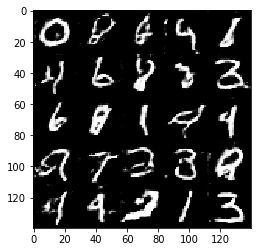

Epoch 2/2... Discriminator Loss: 0.4229... Generator Loss: 1.3537
Epoch 2/2... Discriminator Loss: 0.4977... Generator Loss: 1.1987
Epoch 2/2... Discriminator Loss: 0.2348... Generator Loss: 1.8888
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 4.8647
Epoch 2/2... Discriminator Loss: 0.2681... Generator Loss: 2.5793
Epoch 2/2... Discriminator Loss: 0.2693... Generator Loss: 3.1708
Epoch 2/2... Discriminator Loss: 0.2709... Generator Loss: 1.6461
Epoch 2/2... Discriminator Loss: 0.1755... Generator Loss: 3.4377
Epoch 2/2... Discriminator Loss: 0.1997... Generator Loss: 2.7576
Epoch 2/2... Discriminator Loss: 0.4534... Generator Loss: 1.6096


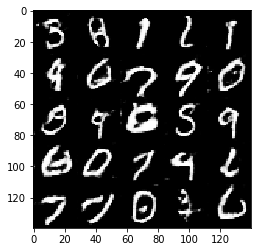

Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 0.9517
Epoch 2/2... Discriminator Loss: 1.2582... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 0.8754... Generator Loss: 1.0538
Epoch 2/2... Discriminator Loss: 0.2615... Generator Loss: 2.0507
Epoch 2/2... Discriminator Loss: 0.2686... Generator Loss: 2.2527
Epoch 2/2... Discriminator Loss: 0.4013... Generator Loss: 1.4964
Epoch 2/2... Discriminator Loss: 0.2584... Generator Loss: 2.7336
Epoch 2/2... Discriminator Loss: 0.1450... Generator Loss: 3.1921
Epoch 2/2... Discriminator Loss: 0.4360... Generator Loss: 4.1589
Epoch 2/2... Discriminator Loss: 0.1281... Generator Loss: 2.8804


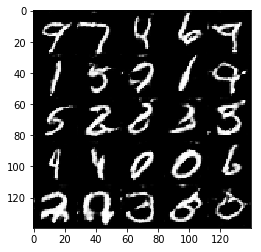

Epoch 2/2... Discriminator Loss: 2.0507... Generator Loss: 0.3512
Epoch 2/2... Discriminator Loss: 0.4766... Generator Loss: 1.6130
Epoch 2/2... Discriminator Loss: 0.6582... Generator Loss: 1.2500
Epoch 2/2... Discriminator Loss: 0.4168... Generator Loss: 1.6820
Epoch 2/2... Discriminator Loss: 0.7398... Generator Loss: 1.2673
Epoch 2/2... Discriminator Loss: 0.2120... Generator Loss: 2.5753
Epoch 2/2... Discriminator Loss: 0.2669... Generator Loss: 2.2081


In [58]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 5.7593
Epoch 1/1... Discriminator Loss: 5.1098... Generator Loss: 0.0516
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 1.3881
Epoch 1/1... Discriminator Loss: 0.3216... Generator Loss: 2.8881
Epoch 1/1... Discriminator Loss: 0.1681... Generator Loss: 4.2072
Epoch 1/1... Discriminator Loss: 0.2504... Generator Loss: 2.2801
Epoch 1/1... Discriminator Loss: 0.1178... Generator Loss: 2.8825
Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 1.5365
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.4511
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 1.2782


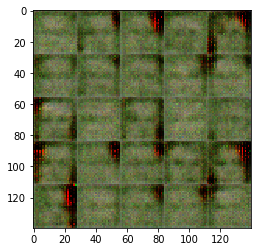

Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 1.7199
Epoch 1/1... Discriminator Loss: 0.7005... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 1.8330
Epoch 1/1... Discriminator Loss: 0.4717... Generator Loss: 1.7177
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.5711
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.3109
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 1.4621
Epoch 1/1... Discriminator Loss: 0.6679... Generator Loss: 1.3063


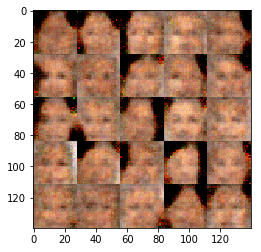

Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.6792... Generator Loss: 0.3063
Epoch 1/1... Discriminator Loss: 0.6572... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 2.3006... Generator Loss: 3.4480
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.9604
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.3996
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.8225
Epoch 1/1... Discriminator Loss: 0.7506... Generator Loss: 1.3194
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 2.0138


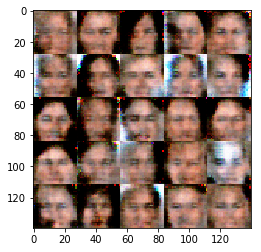

Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 2.3455
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.4313
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.4497
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 1.4118
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 1.9988
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.3691
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 2.7867
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.0492


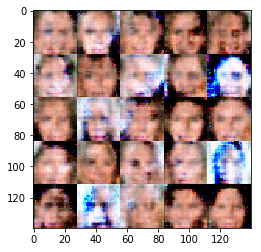

Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 1.3430
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 1.3662
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 1.1921
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 1.3615
Epoch 1/1... Discriminator Loss: 0.7503... Generator Loss: 1.1282


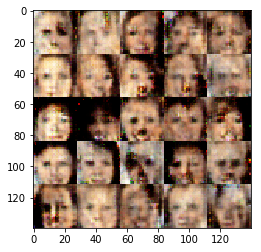

Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 2.1228
Epoch 1/1... Discriminator Loss: 2.1158... Generator Loss: 2.2685
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.6538... Generator Loss: 2.4488


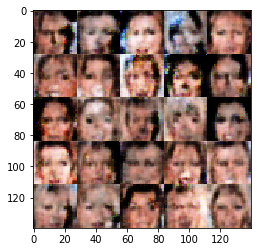

Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.8113
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.4633
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 1.5699
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.2996
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.4425
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 2.7983... Generator Loss: 3.6541


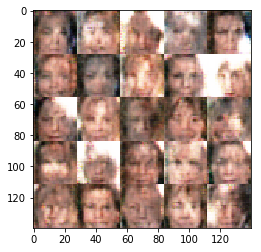

Epoch 1/1... Discriminator Loss: 1.8793... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.9082... Generator Loss: 1.7948
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.6623... Generator Loss: 0.3370
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.2801


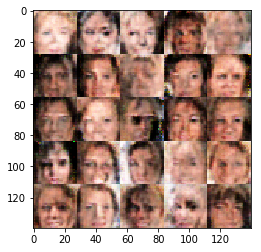

Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.6214... Generator Loss: 1.7134
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.8071


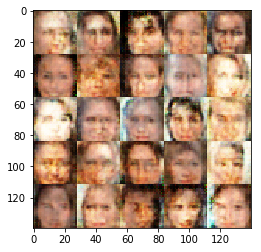

Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.6546... Generator Loss: 0.3672
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.8920


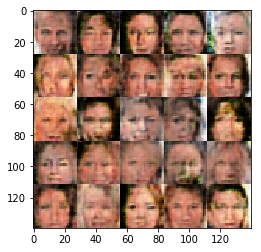

Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 1.2662
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.6151


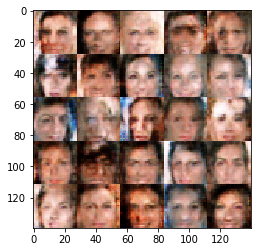

Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.2995
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.8899


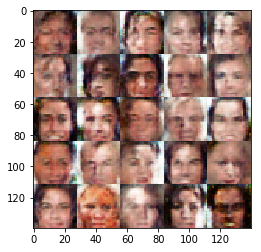

Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 1.4382
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.3787
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.3501


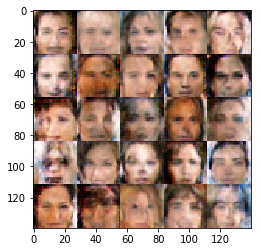

Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 1.2300
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.9261


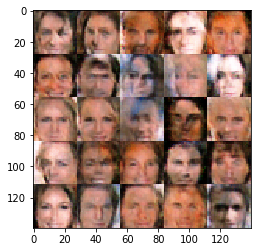

Epoch 1/1... Discriminator Loss: 1.6613... Generator Loss: 0.2875
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.3025


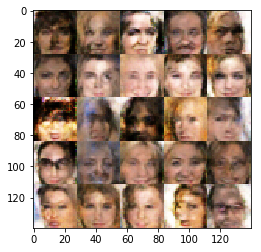

Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.4455
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 1.6103
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.4409
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.2671
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.7983


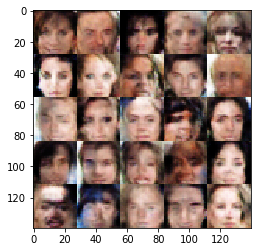

Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 1.3691
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 1.2911
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.4763


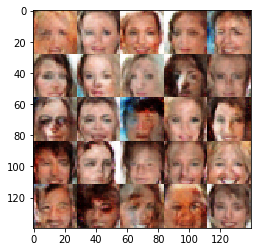

Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 1.7574
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.2398
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 1.4694
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 0.8821


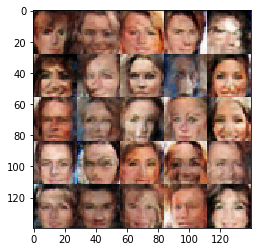

Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.3478
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.3294
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.4621


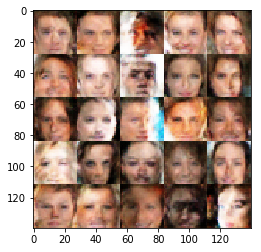

Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.5997... Generator Loss: 0.3348
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.3039
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.8533
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 0.9619


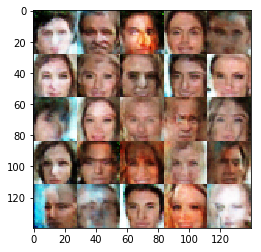

Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.0140
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.6412
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.4646


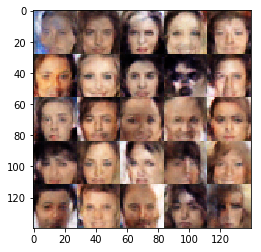

Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 1.4008
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.3813
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.1124


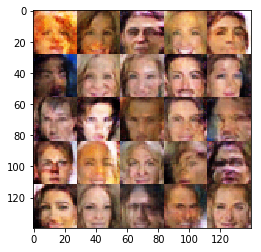

Epoch 1/1... Discriminator Loss: 1.8339... Generator Loss: 0.2336
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.4402
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 1.8090
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.2415
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.6818
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.3349


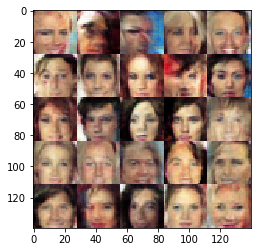

Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.8650
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.9106
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 1.7561
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 0.3034
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.3934


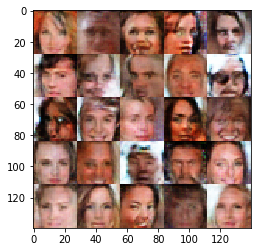

Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.4810
Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 1.5163
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.3484
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.3980
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.0010


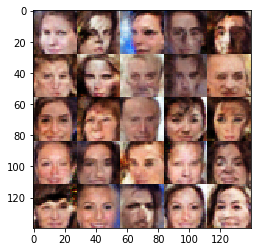

Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.8903
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.8781
Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.3159
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.4607
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.1082
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 0.6562


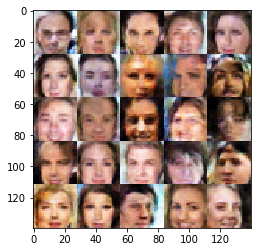

Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.5748
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.3736
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 1.1984
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 0.3948
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 0.9917


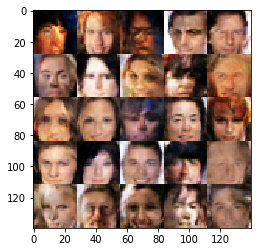

Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.6156
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.9183
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.9095


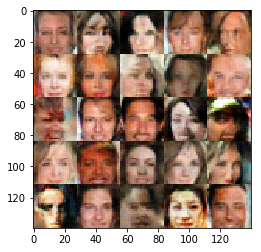

Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.6305
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 2.3465
Epoch 1/1... Discriminator Loss: 0.7603... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 2.3362
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.4917


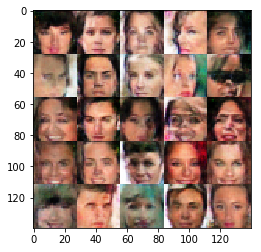

Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.8692
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 1.4760
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 2.0905
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 1.3104
Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 1.8816
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 0.9927


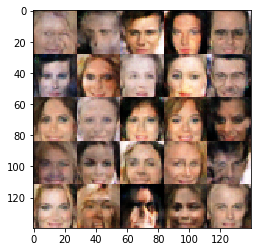

Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.7625
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.3416
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.6795
Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.3982
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 1.3925
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 1.5840
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 1.7945
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 1.8462


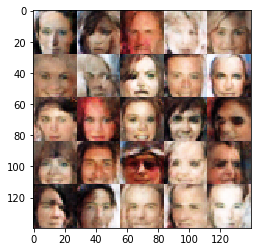

Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.3362
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 1.3586


In [59]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.